# Hypothesis testing

Python activities to complement [*Measurements and their Uncertainties*](http://www.oupcanada.com/catalog/9780199566334.html) (*MU*), Chapter 8, "Hypothesis testing—how good are our models?"

* [Preliminaries](#Preliminaries)
* [The &chi;<sup>2</sup> distribution](#The-$\chi^2$-distribution)
    * [Basic properties](#Basic-properties)
    * [Using &chi;<sup>2</sup> to evaluate a fit](#Using-$\chi^2$-to-evaluate-a-fit)
    * [Exercise 1](#Exercise-1)
* [Scaling uncertainties](#Scaling-uncertainties)
    * [Exercise 2](#Exercise-2)
* [Summary](#Summary)

## Preliminaries
Before proceeding with this notebook you should review the topics from the [Example Fit notebook](A.1-Example-Fit.ipynb) and read *MU* Ch. 8, "Hypothesis testing—how good are our models?", with the following [goals](https://wiki.its.sfu.ca/departments/phys-students/index.php/Reading_goals_for_Hughes_and_Hase#Hypothesis_testing-how_good_are_our_models.3F) in mind.

1. Be able to explain how to use the *&chi;*<sup>2</sup> statistic to test whether a set of measurements are consistent with a theoretical model, and why it is useful in this context; also, be able to apply the *&chi;*<sup>2</sup> test to assess the agreement between an experiment and a theoretical description of it. Specifically,
     1. be able to state the null hypothesis that is being tested with the *&chi;*<sup>2</sup> test: that the model function *f*(*&theta;*;**x**)  with the best-fit parameters $\mathbf{\theta} = \left\{\theta_1,\ldots,\theta_{\mathcal{N} }\right\}$ and independent variables $\mathbf{x} = \{x_1,\ldots,x_N\}$ is consistent with measurements $\mathbf{y} = \{y_1,\ldots,y_N\}$ that have independently known Gaussian uncertainties $\left\{\alpha_1,\ldots,\alpha_N\right\}$ for each measurement;
     2. be able to explain what the term "degrees of freedom" means in the context of a statistical estimate;
     3. be able to calculate the number of degrees of freedom in a fit;
     4. given *N* data points with known uncertainties and a model with $\mathcal{N}$ parameters that are optimized to yield a goodness-of-fit statistic $\chi_\mathrm{min}^2$, be able to assess the quality of the fit, both qualitatively (by comparing $\chi_\mathrm{min}^2$ with the number of degrees of freedom) and quantitatively [by computing $P(\chi_\mathrm{min}^2;\nu)$].
2. Be able to describe a variety of methods, including the *&chi;*<sup>2</sup> test, to assess the quality of a fit (see Sec. 8.5.3).
3. Recognize that the confidence limits for a parameter estimate will be given by the Student's *t*-distribution when the uncertainty is not known independently, and that this is usually the implicit assumption of curve-fitting software; also, be able to explain why the Student *t*-distribution will approach the Gaussian distribution when the number of degrees of freedom is sufficiently large.
4. Recognize that curve-fitting software often scales fit parameter uncertainties automatically, and how this can lead to erroneous assessments of both the fit quality and the parameter uncertainties (see the two **health warnings** in Sec. 8.9); also, recognize the limited context in which scaling uncertainties is appropriate.

The following code cell includes the initialization commands needed for this notebook.

In [1]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import chi2

%matplotlib inline

## The $\chi^2$ distribution

### Basic properties
The $\chi^2(x;\nu)$ distribution is what you get when you take $\nu$ random numbers from the normal distribution $\mathcal{N}(x;\mu=0,\sigma^2=1)$ and take the sum of their squares.

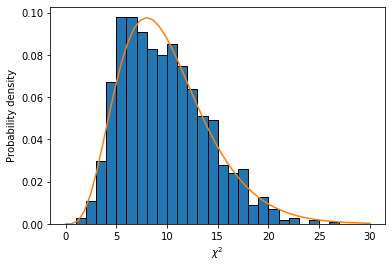

In [2]:
# Seed the RNG
random.seed(0)

# Generate N=1000 sums of squares of nu=10 random numbers
N = 1000
nu = 10
x = random.randn(N,nu)
c2 = np.sum(x**2, axis=1)

# Compute the chi-squared PDF
c2val = np.linspace(0,30)
c2pdf = chi2.pdf(c2val,nu)

# Compare the distribution with the chi-squared PDF
edges = np.arange(30)
plt.hist(c2, bins=edges, range=(0.0, 30.0), density=True, ec='k')
plt.plot(c2val, c2pdf)
plt.xlabel("$\chi^2$")
plt.ylabel("Probability density");

### Using $\chi^2$ to evaluate a fit

When discussing least-squares curve fits the term $\chi^2$ can mean one of three things, depending on the context:
1. The function that we minimize, which involves the data $(\mathbf{x}, \mathbf{y})$, the standard error $\mathbf{\alpha}$, and the model function $f(x;\theta)$ for a set of parameters $\theta$ that we aim to estimate,

$$
\chi^2(\mathbf{\theta};\mathbf{x}, \mathbf{y}, \mathbf{\alpha}) = \sum_{i=1}^N\frac{[y_i - f(x_i;\theta)]^2}{\alpha_i^2};
$$

2. The minimum value of $\chi_\text{min}^2 = \mathop{\text{arg min}}_\theta\chi^2(\mathbf{\theta};\mathbf{x}, \mathbf{y}, \mathbf{\alpha})$ with respect to the parameters $\theta$; and

3. The probability distribution function given by *MU* Eq. (8.3), which we express here in more conventional notation,

$$
\chi^2(x;\nu) = \frac{x^{\frac{\nu}{2}-1}\exp(-x/2)}{2^{\nu/2}\Gamma(\nu/2)}.
$$

Using this terminology to describe the usual procedure for fitting experimental data, we minimize the $\chi^2(\mathbf{\theta};\mathbf{x}, \mathbf{y}, \mathbf{\alpha})$ *function* (1) to obtain the $\chi_\text{min}^2$ *statistic* (2), then compare this statistic to the $\chi^2(x;\nu)$ *distribution* (3) to evaluate the quality of the fit.

Got that? Good. Now let's put it to use. Simulate voltage measurements across a 100 &Omega; resistor for a range of currents, assuming the voltmeter has a 1 mV uncertainty and a 2 mV offset error.

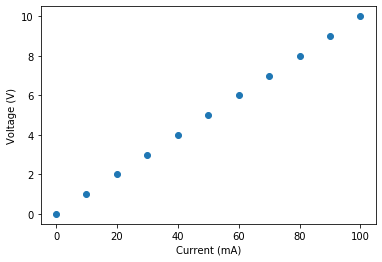

In [3]:
# Seed the RNG
random.seed(0)

# Simulate voltage across a 100 Ohm resistor
R = 100
I_mA = np.arange(0,110,10)
I = I_mA*1e-3

alphaV = 1e-3
Voff = 2e-3
Vm = R*I + Voff + alphaV*random.randn(np.size(I))

# Plot the data
plt.errorbar(I_mA, Vm, fmt='o')
plt.xlabel("Current (mA)")
plt.ylabel("Voltage (V)");

Now define a model function based on Ohm's law and choose an initial guess for the resistance. The voltage uncertainty is too small to be appear on the `errorbar` plot, so we switch to the conventional `plot` command.

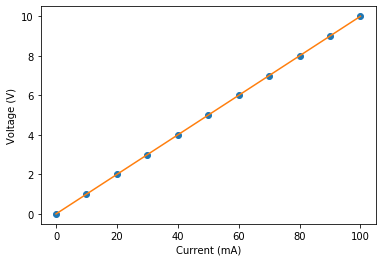

In [4]:
# Define model
def vOhm(current, resistance):
    return current*resistance

# Assign initial guess for resistance and
RInit = 100
Imodel_mA = np.linspace(0,100)
Imodel = 1e-3*Imodel_mA
Vmodel = vOhm(Imodel, RInit)
plt.plot(I_mA, Vm, 'o')
plt.plot(Imodel_mA, Vmodel, '-')
plt.xlabel("Current (mA)")
plt.ylabel("Voltage (V)");

So far, so good. Now run `curve_fit` to improve the fit by adjusting *R* to minimize the $\chi^2$ function (1).

In [5]:
R_fit, R_fit_cov = curve_fit(vOhm, I_mA*1e-3, Vm, p0=[RInit], 
                             sigma=alphaV*np.ones(np.size(Vm)), absolute_sigma=True)
alpha_R = np.sqrt(R_fit_cov[0,0])
print(f"R = {R_fit[0]:.3f} ± {alpha_R:.3f} ohms")

R = 100.034 ± 0.005 ohms


Now check the $\chi^2_\text{min}$ statistic (2).

In [6]:
# Compute and display chi-squared
res = Vm - vOhm(I_mA*1e-3, R_fit)
normres = res/alphaV
chisq = np.sum(normres**2)
print(f"chisq = {chisq:.1f}")

chisq = 44.6


This result signals a problem: we have 11 measurements and 1 fit parameter, so there are 10 statistical degrees of freedom in the fit. The $\chi^2(x;\nu=10)$ distribution (3) has a mean value of 10 and a standard deviation of $\sigma = \sqrt{2\nu}\approx 4.5$, so our result is more than $7\sigma$ above the value expected for such a fit. We can use [`chi2.cdf`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2.html) to compute the precise probability.

In [7]:
# Compute the probability of getting this fit result
dof = 10
cdf = chi2.cdf(chisq, dof)
print(f"Cumulative probability = {cdf:.6f}")
print(f"Significance: {1-cdf:.6f}")

Cumulative probability = 0.999997
Significance: 0.000003


So there is a chance of 3 in a million that we would get such a result at random. Let's look at the residuals to see what might be wrong.

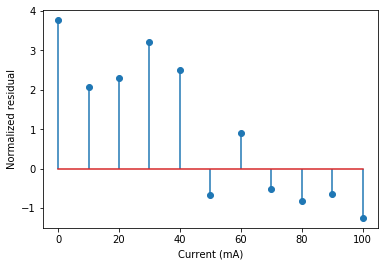

In [8]:
plt.stem(I_mA, normres, use_line_collection=True)
plt.xlabel('Current (mA)')
plt.ylabel('Normalized residual')
plt.xlim(-5,105)
plt.show()

The residuals reveal a strong trend that indicates our model lacks the necessary freedom to achieve a good fit. From the pattern, we can guess that the problem is an offset error. Let's check.

In [9]:
# Define new model
def vOhm_offset(current, resistance, offset):
    return current*resistance + offset

VoffInit = 0
p_fit, p_fit_cov = curve_fit(vOhm_offset, I_mA*1e-3, Vm, p0=[RInit,VoffInit], 
                             sigma=alphaV*np.ones(np.size(Vm)), absolute_sigma=True)
R_fit = p_fit[0]
Voff_fit = p_fit[1]
alpha_R = np.sqrt(p_fit_cov[0,0])
alpha_Voff = np.sqrt(p_fit_cov[1,1])
print(f"R = {R_fit:.3f} ± {alpha_R:.3f} ohms")
print(f"Voff = {Voff_fit:.3f} ± {alpha_Voff:.3f} V")

R = 99.985 ± 0.010 ohms
Voff = 0.003 ± 0.001 V


Note that the resistance uncertainty increased by about a factor of two. This does *not* mean that the fit is not as good as the first! If the fit quality is better, then the larger uncertainty is actually a more *accurate* estimate of the uncertainty in *R*. Let us check the fit quality now, noting that the extra fit parameter brings the number of statistical degrees of freedom down to 9.

In [10]:
# Compute and display chi-squared
res_offset = Vm - vOhm_offset(I_mA*1e-3, R_fit, Voff_fit)
normres_offset = res_offset/alphaV
chisq_offset = np.sum(normres_offset**2)
print(f"chisq_offset = {chisq_offset:.1f}")

# Compute the probability of getting this fit result
dof_offset = 9
cdf_offset = chi2.cdf(chisq_offset, dof)
print(f"Cumulative probability = {cdf_offset:.6f}")
print(f"Significance: {1-cdf_offset:.6f}")

chisq_offset = 7.0
Cumulative probability = 0.278715
Significance: 0.721285


Much better! To be sure, though, we need to check that the normalized residuals are consistent with a standard normal distribution.

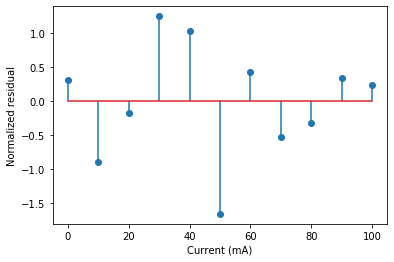

In [11]:
plt.stem(I_mA, normres_offset, use_line_collection=True)
plt.xlabel('Current (mA)')
plt.ylabel('Normalized residual')
plt.xlim(-5,105)
plt.show()

No clear pattern emerges from these residuals, so we can accept the fit and report the parameters with their uncertainties with confidence. Note that we can still get an acceptable $\chi^2_\text{min}$ for a poor model if we also overestimate $\alpha$, so it is essential to examine the residuals in addition to $\chi^2_\text{min}$. Also, note that the *reduced* $\chi^2$ statistic [*MU* Eq. (8.6)],
$$
\chi^2_\nu = \frac{\chi^2_\text{min}}{\nu},
$$
has an expectation value of 1, but a standard deviation $\sigma = \sqrt{2/\nu}$, which depends on the number of degrees of freedom. This means that $\chi^2_\nu$ statistic can provide a false sense of security if $\nu$ is large, since the expected deviation from 1 will be small in that case. The reduced $\chi^2$ is useful for quickly checking if a fit for obvious problems, but for quantitative evaluation you should always use the $\chi^2$ cumulative distribution function to compute the significance of your $\chi^2_\text{min}$ statistic for the given number of degrees of freedom.

### Exercise 1
Import the data in `data/pendulum.csv`, which contains simulated measurements of a pendulum period $T$ as a function of its length $L$. Fit the data to the model
$$
T = 2\pi\sqrt{L/g},
$$
where $g$ is the acceleration of gravity. Report the result of the fit, its $1\sigma$ uncertainty, the $\chi^2_\text{min}$ statistic, and the significance of this statistic. Plot the normalized residuals and evaluate their consistency with the assumption of Gaussian random errors with the given $\alpha_T$.

In [12]:
# Code cell for Exercise 1
# Use this cell for your response, adding cells if necessary.

## Scaling uncertainties
It is worth noting that the $\chi^2$ function is a function of three quantities, all of which are important:

1. The data, $\mathbf{x}, \mathbf{y}$;
2. The physical model, $\mathbf{f}(\mathbf{\theta};\mathbf{x})$; and
3. The noise model, which in least-squares analysis we assume to be normally distributed random values with zero mean and standard deviation $\mathbf{\alpha}$.

So far we have looked to the $\chi^2_\text{min}$ statistic to evaluate how well the model fits the data, assuming that $\mathbf{\alpha}$ is known from independent measurements. But the noise measurements are also susceptible to both random and systematic errors, and an error of only 30% or 40% in $\mathbf{\alpha}$ will cause $\chi^2_\text{min}$ to change by *a factor of two*. This can produce a value for $\chi^2_\text{min}$ that signals a poor fit even though the physical model is perfectly satisfactory, as the example below shows.

We simulate the time $t$ for an object to fall a distance $d$ from rest. We assume that a stopwatch with 1 ms precision was used in the measurements, and take that as our initial estimate of the timing uncertainty. The true timing uncertainty, however, is 5 ms, and is limited by the stopwatch user, not the stopwatch itself.

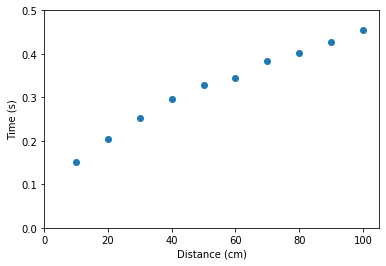

In [13]:
# Seed the RNG
random.seed(0)

# Simulate free-fall measurements
g = 9.81 # m/s^2
d_cm = np.arange(10,110,10) # cm
d = 1e-2*d_cm

alpha_t = 5e-3
alpha_t_est = 1e-3

tm = np.sqrt(2*d/g) + alpha_t*random.randn(np.size(d))

# Round to the nearest millisecond
tm = np.round(tm, decimals=3)

# Plot the data
plt.errorbar(d_cm, tm, fmt='o')
plt.xlabel("Distance (cm)")
plt.ylabel("Time (s)")
plt.xlim(0,105)
plt.ylim(0,0.5);

As before, we define the physical model, select an initial guess, and compare with the model before proceeding with the automated fit.

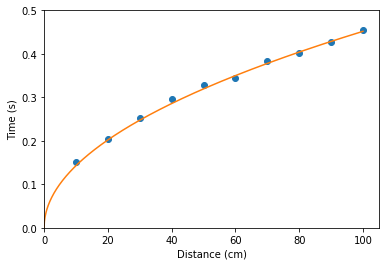

In [14]:
# Define model
def t_fall(distance, g):
    return np.sqrt(2*distance/g)

# Assign initial guess and plot
# Use 1000 points for the model to give
# a smooth curve near (0,0)
gInit = 9.8
dmodel_cm = np.linspace(0,100,1000)
dmodel = 1e-2*dmodel_cm
tmodel = t_fall(dmodel, gInit)
plt.plot(d_cm, tm, 'o')
plt.plot(dmodel_cm, tmodel, '-')
plt.xlabel("Distance (cm)")
plt.ylabel("Time (s)")
plt.xlim(0,105)
plt.ylim(0,0.5);

Everything looks good, so we proceed with the fit.

In [15]:
g_fit, g_fit_cov = curve_fit(t_fall, d_cm*1e-2, tm, p0=[gInit], 
                             sigma=alpha_t_est*np.ones(np.size(tm)), absolute_sigma=True)
alpha_g = np.sqrt(g_fit_cov[0,0])
print(f"g = {g_fit[0]:.2f} ± {alpha_g:.2f} m/s^2")

g = 9.63 ± 0.02 m/s^2


Now check the $\chi^2_\text{min}$ statistic.

In [16]:
# Compute and display chi-squared
res = tm - t_fall(d_cm*1e-2, g_fit)
normres = res/alpha_t_est
chisq = np.sum(normres**2)
print(f"chisq = {chisq:.1f}")

chisq = 300.6


Obviously there is a problem: $\chi^2_\nu = \chi^2_\text{min}/\nu > 33$! As the code cell below shows, the probability of obtaining $\chi^2_\text{min}\leq 300.6$ is so close to 1 that the difference `1 - cdf` is below the numerical precision. If we really want to know the value, we can use the *survival function* method, [`sf`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.sf.html), which is designed to compute small deviations in `1 - cdf` with greater precision.

In [17]:
# Compute the probability of getting this fit result
dof = 9
cdf = chi2.cdf(chisq, dof)
sig = chi2.sf(chisq, dof)
print(f"Cumulative probability = {cdf:.6f}")
print(f"Significance (1-cdf method): {1 - cdf:.6f}")
print(f"Significance (sf method): {sig:.6e}")

Cumulative probability = 1.000000
Significance (1-cdf method): 0.000000
Significance (sf method): 1.980971e-59


We saw in the last example that residual analysis can help identify an inaccurate physical model, which will typically produce residuals that *lack* randomness. Residual analysis can also help diagnose problems with the noise model. In this case, the residuals will typically be random, but with a distribution that is different from what we expect.

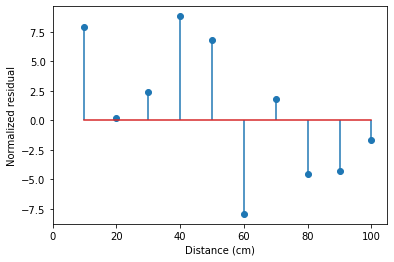

In [18]:
plt.stem(d_cm, normres, use_line_collection=True)
plt.xlabel("Distance (cm)")
plt.ylabel('Normalized residual')
plt.xlim(0,105)
plt.show()

As discussed in *MU* Sec. 8.9, sometimes this can be addressed by simply rescaling your original estimate of $\mathbf{\alpha}$ by
$$
S = \sqrt{\frac{\chi^2_\text{min}}{\nu}} = \sqrt{\chi^2_\nu},
$$
so that the resulting $\chi'^2_\text{min} = S\chi^2_\text{min}$ matches the number of degrees of freedom exactly. Of course you forfeit the ability to use $\chi'^2_\text{min}$ as evidence of fit quality when you do this, so it is usually preferable to just go back and do a more careful measurement of the noise. This is definitely the case in this example, where $\chi^2_\text{min}$ indicates such a poor fit.

When $S\approx 1$, though, it may be advantageous to scale the residuals to improve the accuracy of the *parameter uncertainty,* since the parameter uncertainty estimate given by `curve_fit` depends on $\chi^2_\text{min}$. The following code cell computes the scale factor for our example, then uses this to revise $\alpha_g$. Another way to achieve the same result is to simply set `absolute_sigma=False` in the `curve_fit` algorithm—this will compute the fit by treating the values assigned to `sigma` as *relative uncertainties*, with an overall scale factor given by $S$ above. The defaults are `absolute_sigma=False` and `sigma` set to a vector of ones with the same size as the `y` data, so that when both `sigma` and `absolute_sigma` are omitted, `curve_fit` minimizes

$$
\chi^2(\mathbf{\theta};\mathbf{x}, \mathbf{y}, \mathbf{\alpha}=\mathbf{1}) = \sum_{i=1}^N[y_i - f(x_i;\theta)]^2.
$$


In [36]:
# Determine the scaling factor
S = np.sqrt(chisq/dof)
print(f"Scale factor: {S:.3f}")

# Scale measurement uncertainty by S
print(f"S*alpha_t_est = {1e3*S*alpha_t_est:.2f} ms")

# Compare with true measurement uncertainty
print(f"True alpha_t = {1e3*alpha_t:.2f}")

# Scale parameter uncertainty by S
print(f"g = {g_fit[0]:.2f} ± {S*alpha_g:.2f} m/s^2 (scaled uncertainty)")

# Repeat fit with absolute_sigma=False
g_fit_scaled, g_fit_cov_scaled = curve_fit(t_fall, d_cm*1e-2, tm, p0=[gInit], 
                             sigma=alpha_t_est*np.ones(np.size(tm)), absolute_sigma=False)
alpha_g_scaled = np.sqrt(g_fit_cov_scaled[0,0])
print(f"g = {g_fit_scaled[0]:.2f} ± {alpha_g_scaled:.2f} m/s^2 (absolute_sigma=False)")

# Repeat fit without sigma or absolute_sigma keywords
g_fit_nosig, g_fit_cov_nosig = curve_fit(t_fall, d_cm*1e-2, tm, p0=[gInit])
alpha_g_nosig = np.sqrt(g_fit_cov_nosig[0,0])
print(f"g = {g_fit_nosig[0]:.2f} ± {alpha_g_nosig:.2f} m/s^2 (no sigma)")

Scale factor: 5.779
S*alpha_t_est = 5.78 ms
True alpha_t = 5.00
g = 9.63 ± 0.10 m/s^2 (scaled uncertainty)
g = 9.63 ± 0.10 m/s^2 (absolute_sigma=False)
g = 9.63 ± 0.10 m/s^2 (no sigma)


### Exercise 2
The following code cell uses [`genfromtxt`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.genfromtxt.html) to import a data file from the [NIST Standard Reference Database](https://www.itl.nist.gov/div898/strd/index.html). Fit this data to the model

$$
y(\mathbf{x};\mathbf{A}, \mathbf{\kappa}) = A_1\exp(-\kappa_1 x) + A_2\exp(-\kappa_2 x) + A_3\exp(-\kappa_3 x)
$$

and report the best-fit values for $\mathbf{A}$ and $\mathbf{\kappa}$ and their estimated uncertainties. Note that the data file does not contain values for $\mathbf{\alpha}_y$. Use $\chi^2_\text{min}$ to estimate $\mathbf{\alpha}_y$, assuming it is uniform for all $\mathbf{y}$.

In [32]:
# Code cell for Exercise 2
# Use this cell for your response, adding cells if necessary.
y, x = np.genfromtxt('https://www.itl.nist.gov/div898/strd/nls/data/LINKS/DATA/Lanczos3.dat', 
                  skip_header=60, unpack=True)

## Summary
Here is a list of what you should be able to do after completing this notebook.
* Compute $\chi^2_\text{min}$ for a fit and use it to evaluate the fit quality
* Use the [`cdf`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.cdf.html) method of the [`chi2`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2.html) distribution object to compute the significance of a given value for $\chi^2_\text{min}$
* Use residual analysis to identify lack of fit between the data and the physical model, the data and the noise model, or both
* Use residual analysis to guide revision of an unsatisfactory physical model or noise model
* Recognize that the `absolute_sigma` optional keyword determines whether the `curve_fit` function uses unscaled (`absolute_sigma=False`) or scaled (`absolute_sigma=True`) uncertainties
* Use the residuals to estimate the measurement uncertainty when an independent estimate is unavailable

##### About this notebook
Notebook by J. S. Dodge, 2019. Available from [SFU GitLab](https://gitlab.rcg.sfu.ca/jsdodge/data-analysis-python). The notebook text is licensed under the Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 International License. See more at [Creative Commons](http://creativecommons.org/licenses/by-nc-nd/4.0/). The notebook code is open source under the [MIT License](https://opensource.org/licenses/MIT).